In [1]:
import numpy as np
import mxnet as mx
import time
import pandas as pd

import cv2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data0 = pd.read_csv('data1/data.csv', names=['name','state'])

In [4]:
data0

,name,state
0,closedleft.jpg,initial
1,closedmiddle.jpg,initial
2,closedright.jpg,initial
3,ctrlleft-1.jpg,number
4,ctrlleft-2.jpg,lower alphabet
5,ctrlleft-3.jpg,upper alphabet
6,ctrlleft-4.jpg,ctrl
7,ctrlleft-5.jpg,ready
8,ctrlmiddle-1.jpg,number
9,ctrlmiddle-2.jpg,lower alphabet


In [5]:
data0['state'].unique()

array([' initial', ' number', ' lower alphabet', ' upper alphabet',
       ' ctrl', ' ready', ' alt', ' special character', '1', '2', '3', '4',
       '5', '6', '7', '8', '9', '0', ' space'], dtype=object)

In [6]:
num_class = len(data0['state'].unique())
ges_to_num = dict({(g,i) for i, g in enumerate(data0['state'].unique())})
num_to_ges = dict({(i,g) for i, g in enumerate(data0['state'].unique())})
ges_to_num

{' alt': 6,
 ' ctrl': 4,
 ' initial': 0,
 ' lower alphabet': 2,
 ' number': 1,
 ' ready': 5,
 ' space': 18,
 ' special character': 7,
 ' upper alphabet': 3,
 '0': 17,
 '1': 8,
 '2': 9,
 '3': 10,
 '4': 11,
 '5': 12,
 '6': 13,
 '7': 14,
 '8': 15,
 '9': 16}

In [7]:
data0 = data0.replace({'state':ges_to_num})

In [8]:
data0.shape[0]

33

In [9]:
labels = np.empty((data0.shape[0]))

res_width, res_height = 200, 200
imgs = np.empty(shape=(data0.shape[0],1,res_width,res_height))
imgs.shape, labels.shape

((33, 1, 200, 200), (33,))

In [10]:
prefix = 'data1/pic/'
for i, (im_name, state) in enumerate(data0.values):
    im_path = prefix + im_name
    
    img = cv2.imread(im_path, 0)
    res = cv2.resize(img,(200, 200), interpolation = cv2.INTER_CUBIC)
    imgs[i][0] = res
    labels[i] = state

In [14]:
train_data, train_label = imgs, labels
# test_data, test_label = imgs[23:], labels[2:]
train_data.shape, train_label.shape#, test_data.shape, test_label.shape

((33, 1, 200, 200), (33,))

In [16]:
batch_size = 5
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True)
# eval_iter = mx.io.NDArrayIter(test_data, test_label, batch_size)

In [17]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

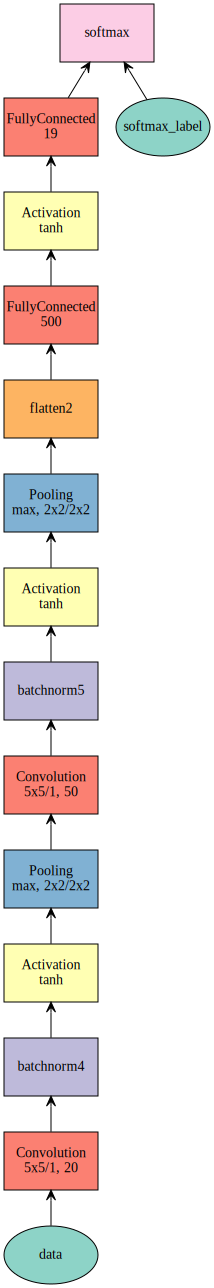

In [23]:
data = mx.sym.var('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20, name='conv1')
bn1 = mx.sym.BatchNorm(conv1, fix_gamma=True)
tanh1 = mx.sym.Activation(data=bn1, act_type='tanh')
pool1 = mx.sym.Pooling(data=tanh1, pool_type='max', kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50, name='conv2')
bn2 = mx.sym.BatchNorm(conv2, fix_gamma=True)
tanh2 = mx.sym.Activation(data=bn2, act_type='tanh')
pool2 = mx.sym.Pooling(data=tanh2, pool_type='max', kernel=(2,2), stride=(2,2))

flat = mx.sym.flatten(data=pool2)
fc1 = mx.sym.FullyConnected(data=flat, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type='tanh')

# drop = mx.symbol.Dropout(tanh3)
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=num_class)

convnet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

mx.viz.plot_network(convnet)

In [33]:
model = mx.mod.Module(symbol=convnet, context=mx.gpu())

In [34]:
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params(initializer=mx.init.Uniform(scale=.1))
model.init_optimizer(optimizer='sgd', optimizer_params={'learning_rate':0.1})

metric = mx.metric.Accuracy()

In [35]:
for epoch in range(120):
    train_iter.reset()
    metric.reset()
    
    st = time.time()
    for batch in train_iter:
        model.forward(data_batch=batch, is_train=True)
        model.update_metric(metric, batch.label)
        model.backward()
        model.update()
        
    et = time.time()-st
    print('Epoch %d, Training %s, Time %.2f' % (epoch, metric.get(), et))

Epoch 0, Training ('accuracy', 0.05714285714285714), Time 0.31
Epoch 1, Training ('accuracy', 0.02857142857142857), Time 0.28
Epoch 2, Training ('accuracy', 0.08571428571428572), Time 0.26
Epoch 3, Training ('accuracy', 0.08571428571428572), Time 0.25
Epoch 4, Training ('accuracy', 0.14285714285714285), Time 0.25
Epoch 5, Training ('accuracy', 0.2), Time 0.25
Epoch 6, Training ('accuracy', 0.08571428571428572), Time 0.25
Epoch 7, Training ('accuracy', 0.08571428571428572), Time 0.25
Epoch 8, Training ('accuracy', 0.17142857142857143), Time 0.25
Epoch 9, Training ('accuracy', 0.2571428571428571), Time 0.25
Epoch 10, Training ('accuracy', 0.22857142857142856), Time 0.25
Epoch 11, Training ('accuracy', 0.11428571428571428), Time 0.25
Epoch 12, Training ('accuracy', 0.2571428571428571), Time 0.25
Epoch 13, Training ('accuracy', 0.2), Time 0.25
Epoch 14, Training ('accuracy', 0.17142857142857143), Time 0.25
Epoch 15, Training ('accuracy', 0.11428571428571428), Time 0.25
Epoch 16, Training (

In [36]:
model.score(train_iter, metric)

[('accuracy', 0.8857142857142857)]

In [38]:
ls data1

data.csv  pic/  test-crop.png


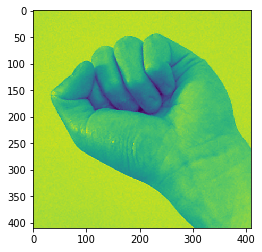

In [41]:
# I took a picture of my hand
pred_im = cv2.imread('data1/test-crop.png', 0)
plt.imshow(pred_im)

In [42]:
pred_im.shape

(410, 410)

In [43]:
pred_res = cv2.resize(pred_im,(200, 200), interpolation = cv2.INTER_CUBIC)
plt.imshow(pred_res)

In [50]:
test_ = np.empty((1,1,200,200))
test_[0][0] = pred_res
lb = np.array([0])

In [51]:
test_.shape, lb.shape

((1, 1, 200, 200), (1,))

In [52]:
eval_iter = mx.io.NDArrayIter(test_, lb, 1)

In [57]:
# test picture with label 0
pred = model.predict(eval_iter).asnumpy()

In [59]:
pred.argmax() # correct!

0